In [1]:
import os
import librosa
import numpy as np
import pywt

In [2]:
data_path = os.path.join(os.getcwd(), "recordings_actividad_7")  # Carpeta que contiene todos los audios.

# Función para cargar los datos
def load_data(data_path):
    labels = []
    features = []
    max_length = 0  # Para almacenar la longitud máxima de coeffs_flat
    
    # Primera pasada: encontrar la longitud máxima de coeffs_flat
    for file in os.listdir(data_path):
        if file.endswith(".wav"):
            file_path = os.path.join(data_path, file)
            audio, sr = librosa.load(file_path, sr=None)
            coeffs = pywt.wavedec(audio, 'db1', level=4)
            coeffs_flat = np.concatenate(coeffs)
            if len(coeffs_flat) > max_length:
                max_length = len(coeffs_flat)
    
    # Segunda pasada: rellenar o truncar los coeficientes
    for file in os.listdir(data_path):
        if file.endswith(".wav"):
            file_path = os.path.join(data_path, file)
            audio, sr = librosa.load(file_path, sr=None)
            coeffs = pywt.wavedec(audio, 'db1', level=4)
            coeffs_flat = np.concatenate(coeffs)
            
            # Rellenar con ceros si es necesario
            if len(coeffs_flat) < max_length:
                padding = max_length - len(coeffs_flat)
                coeffs_flat = np.pad(coeffs_flat, (0, padding), mode='constant')
            # Truncar si es necesario
            elif len(coeffs_flat) > max_length:
                coeffs_flat = coeffs_flat[:max_length]
            
            # Guardar características y etiquetas
            features.append(coeffs_flat)
            labels.append(int(file[0]))  # El primer carácter del nombre del archivo es la etiqueta
            
    return np.array(features), np.array(labels)

features, labels = load_data(data_path)

C:\Users\USER\anaconda33\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [3]:
print(f"Total de grabaciones: {len(features)}")

Total de grabaciones: 1373


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Normalizar características
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Construir el modelo
model = models.Sequential([
    layers.Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
    layers.Conv1D(32, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),  # Dropout en la primera capa densa, con 40% de desactivación
    layers.Dense(64, activation='relu'),  # Puedes agregar una segunda capa densa si lo prefieres
    layers.Dropout(0.4),  # Dropout después de la segunda capa densa también
    layers.Dense(10, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

C:\Users\USER\anaconda33\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 10505, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 10503, 32)           │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 5251, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 5249, 64)            │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 2624, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 167936)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      21,495,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,511,178 (82.06 MB)

 Trainable params: 21,511,178 (82.06 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping
#Si durante 3 epocas no se ve una mejora lo detiene
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Entrenar el modelo con EarlyStopping
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - accuracy: 0.2089 - loss: 3.7674 - val_accuracy: 0.3227 - val_loss: 1.8164
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - accuracy: 0.2685 - loss: 1.9991 - val_accuracy: 0.3773 - val_loss: 1.5907
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.3224 - loss: 1.6592 - val_accuracy: 0.4864 - val_loss: 1.3930
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.3873 - loss: 1.4831 - val_accuracy: 0.5091 - val_loss: 1.2645
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.5172 - loss: 1.2236 - val_accuracy: 0.6318 - val_loss: 1.0881
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.5496 - loss: 1.0745 - val_accuracy: 0.6455 - val_loss: 1.0226
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.6429 - loss: 0.9196 - val_accuracy: 0.6636 - val_loss: 0.9454
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - accuracy: 0.7307 - loss: 0.7580 - val_accuracy: 0.

In [7]:
# Evaluar el modelo
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7644 - loss: 1.9610
Precisión en el conjunto de prueba: 0.7491


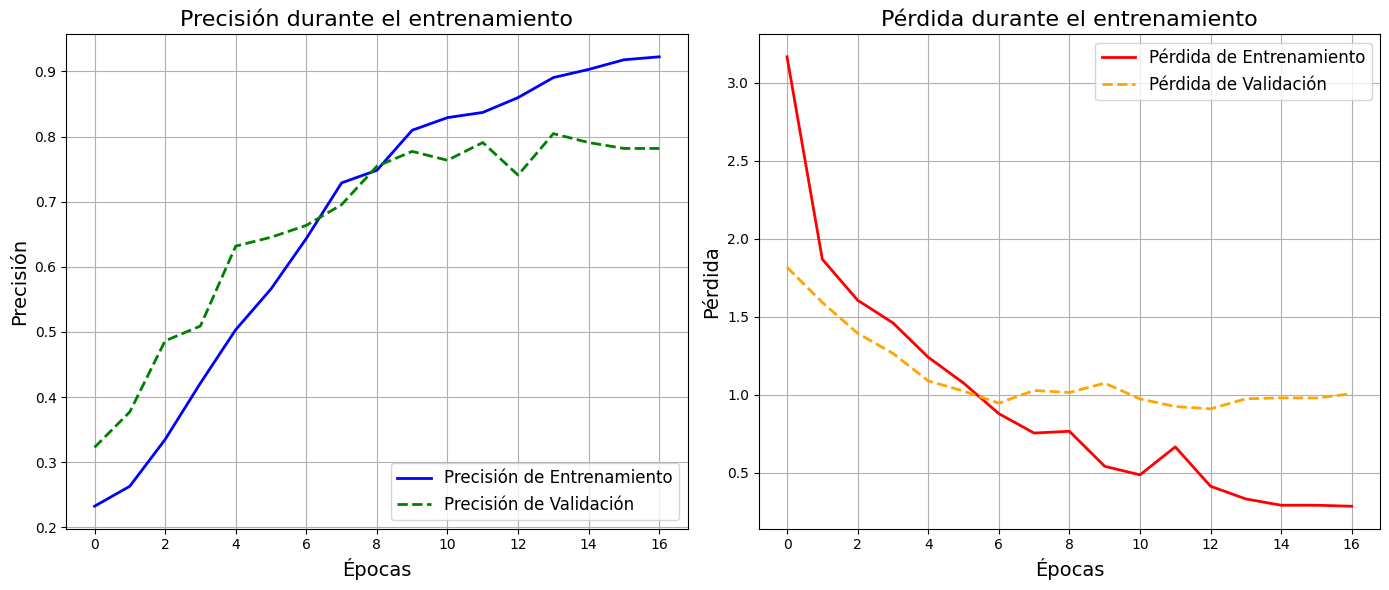

In [11]:
import matplotlib.pyplot as plt

# Mejora de gráficos de precisión y pérdida durante el entrenamiento
plt.figure(figsize=(14, 6))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento', color='b', linestyle='-', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Precisión de Validación', color='g', linestyle='--', linewidth=2)
plt.title('Precisión durante el entrenamiento', fontsize=16)
plt.xlabel('Épocas', fontsize=14)
plt.ylabel('Precisión', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento', color='r', linestyle='-', linewidth=2)
plt.plot(history.history['val_loss'], label='Pérdida de Validación', color='orange', linestyle='--', linewidth=2)
plt.title('Pérdida durante el entrenamiento', fontsize=16)
plt.xlabel('Épocas', fontsize=14)
plt.ylabel('Pérdida', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.savefig("actividad_7_epocas_png", dpi=300)
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7644 - loss: 1.9610
Precisión en el conjunto de prueba: 0.7491
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


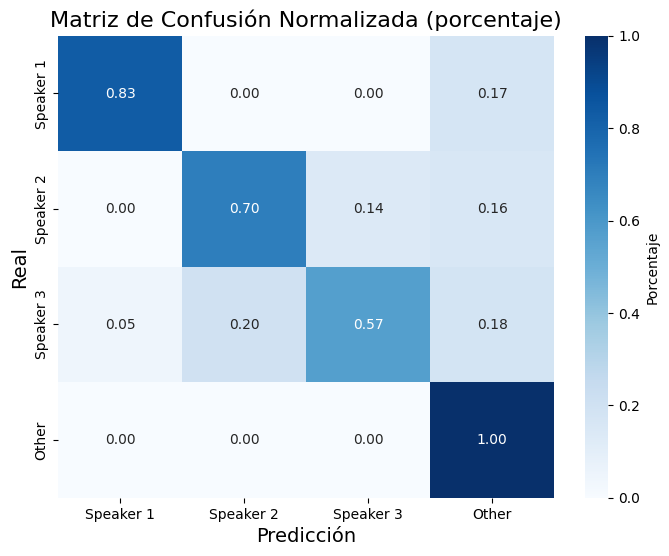

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Evaluar el modelo
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Obtener las predicciones del modelo
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Filtrar las predicciones para que solo se consideren las clases 1, 2, 3, 4 (Other)
y_pred_classes = np.where((y_pred_classes >= 1) & (y_pred_classes <= 3), y_pred_classes, 4)

# Matriz de Confusión con porcentajes
cm = confusion_matrix(y_test, y_pred_classes, labels=[1, 2, 3, 4])
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Convertir a porcentaje

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Speaker 1", "Speaker 2", "Speaker 3", "Other"], 
            yticklabels=["Speaker 1", "Speaker 2", "Speaker 3", "Other"], cbar_kws={'label': 'Porcentaje'})
plt.title('Matriz de Confusión Normalizada (porcentaje)', fontsize=16)
plt.xlabel('Predicción', fontsize=14)
plt.ylabel('Real', fontsize=14)
plt.savefig("actividad_7_matriz.png", dpi=300)
plt.show()


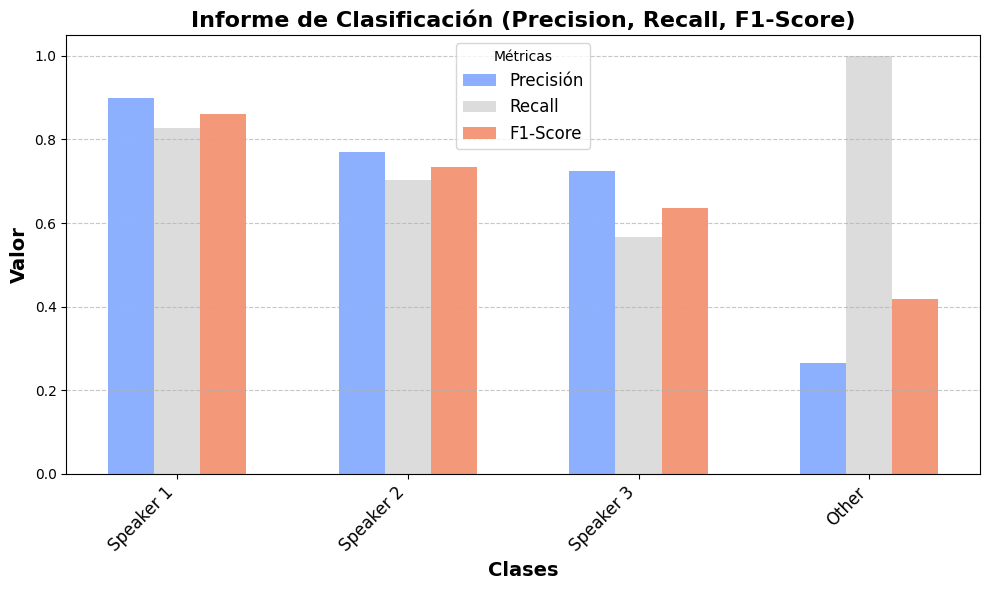

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report

# Obtener el reporte de clasificación como un diccionario
report = classification_report(y_test, y_pred_classes, labels=[1, 2, 3, 4], target_names=["Speaker 1", "Speaker 2", "Speaker 3", "Other"], output_dict=True)

# Convertir el reporte en un DataFrame para una mejor visualización
report_df = pd.DataFrame(report).transpose()

# Configurar la gráfica
fig, ax = plt.subplots(figsize=(10, 6))

# Crear una paleta de colores suaves usando seaborn
colors = sns.color_palette("coolwarm", n_colors=3)  # Usando una paleta de 3 colores (puedes elegir otra)

# Graficar barras para cada métrica: precision, recall, f1-score
bar_width = 0.2
index = np.arange(len(report_df) - 3)  # Excluimos el "accuracy" y el "macro avg" y "weighted avg"

# Crear las barras con los nuevos colores
ax.bar(index - bar_width, report_df["precision"][:-3], bar_width, label="Precisión", color=colors[0])
ax.bar(index, report_df["recall"][:-3], bar_width, label="Recall", color=colors[1])
ax.bar(index + bar_width, report_df["f1-score"][:-3], bar_width, label="F1-Score", color=colors[2])

# Etiquetas y título
ax.set_xlabel('Clases', fontsize=14, fontweight='bold')
ax.set_ylabel('Valor', fontsize=14, fontweight='bold')
ax.set_title('Informe de Clasificación (Precision, Recall, F1-Score)', fontsize=16, fontweight='bold')
ax.set_xticks(index)
ax.set_xticklabels(report_df.index[:-3], rotation=45, ha='right', fontsize=12)  # Excluimos "accuracy", "macro avg", "weighted avg"
ax.legend(title='Métricas', fontsize=12)

# Mejorar la presentación de la gráfica
ax.grid(axis='y', linestyle='--', alpha=0.7)  # Añadir una cuadrícula para mayor claridad
plt.tight_layout()

# Guardar la gráfica como imagen (PNG)
plt.savefig("actividad_7_classification_report.png", dpi=300)

# Mostrar la gráfica en pantalla
plt.show()